In [1]:
import numpy as np
import matplotlib.pylab as plt
import time
from helper import get_clean_project_name
from pyiron_atomistics import Project
from pyiron_atomistics.atomistics.structure.atoms import ase_to_pyiron, pyiron_to_ase
import pyiron_gpl
import seaborn as sns
import pandas as pd
from pychromatic import Multiplot
from pychromatic.colors import accent
from scipy.optimize import curve_fit
colors = {"g": "#1b9e77", "r": "#d95f02", "b": "#7570b3"}

/home/menon/miniconda3/envs/potentials2023/lib/python3.10/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
def birch_murnaghan(vol, V0, E0, B0, Bp):    
    eta = (vol/V0)**(1.0/3.0)
    E = E0 + 9.0*B0*V0/16.0 * (eta**2-1.0)**2 * (6.0 + Bp*(eta**2-1.0) - 4.0*eta**2)
    return E

def fit_bm(vol, en):
    a, b, c = np.polyfit(vol, en, 2)
    V0 = -b/(2*a)
    E0 = a*V0**2 + b*V0 + c
    B0 = 2*a*V0
    Bp = 4.0
    popt, pcov = curve_fit(birch_murnaghan, vol, en, p0=[V0, E0, B0, Bp])
    return popt

In [3]:
pr = Project("validation_LiAl2")

In [4]:
table = pr.load('table_murn')
data_murn = table.get_dataframe()
df_dft_ref = pd.read_pickle("dft_ref_2.pckl")

In [5]:
def get_en_vol(pot, compound, crystal_structure, points=False):
    df = data_murn.loc[(data_murn.potential==pot) & (data_murn.compound==compound) & (data_murn.crystal_structure==crystal_structure)]
    #print(df.job_id)
    murn_job = pr.load(df.job_id.values[0])
    murn_df = murn_job.output_to_pandas()
    vol = murn_df["volume"]/len(murn_job.get_structure())
    en = murn_df["energy"]/len(murn_job.get_structure())
    popt = fit_bm(vol, en)
    volfit = np.linspace(min(vol), max(vol), 10000)
    enfit = birch_murnaghan(volfit, popt[0], popt[1], popt[2], popt[3])
    return volfit, enfit

def get_en_vol_dft(compound):
    df1 = df_dft_ref[df_dft_ref["compound"]==compound]
    vol = df1["volume"]
    en = df1["energy_per_atom"]
    popt = fit_bm(vol, en)
    volfit = np.linspace(min(vol), max(vol), 10000)
    enfit = birch_murnaghan(volfit, popt[0], popt[1], popt[2], popt[3])
    return volfit, enfit

# Normal EV curves

2023-12-08 10:47:06,126 - pyiron_log - DEBUG - sql_query: {'job': 'murn_job_Al_fcc', 'project': '/mnt/c/Users/menon/Documents/winrepos/projects-workshops/potentials-workshop-2022/validation/validation_LiAl2/AlLi_eam/'}
2023-12-08 10:47:06,128 - pyiron_log - DEBUG - sql_query: {'job': 'murn_job_Al_fcc', 'project': '/mnt/c/Users/menon/Documents/winrepos/projects-workshops/potentials-workshop-2022/validation/validation_LiAl2/AlLi_eam/'}
2023-12-08 10:47:06,134 - pyiron_log - DEBUG - sql_query: {'job': 'murn_job_Al_fcc', 'project': '/mnt/c/Users/menon/Documents/winrepos/projects-workshops/potentials-workshop-2022/validation/validation_LiAl2/AlLi_eam/'}
2023-12-08 10:47:06,135 - pyiron_log - DEBUG - sql_query: {'job': 'murn_job_Al_fcc', 'project': '/mnt/c/Users/menon/Documents/winrepos/projects-workshops/potentials-workshop-2022/validation/validation_LiAl2/AlLi_eam/'}
2023-12-08 10:47:06,143 - pyiron_log - DEBUG - Not supported parameter used!
2023-12-08 10:47:06,144 - pyiron_log - DEBUG - 

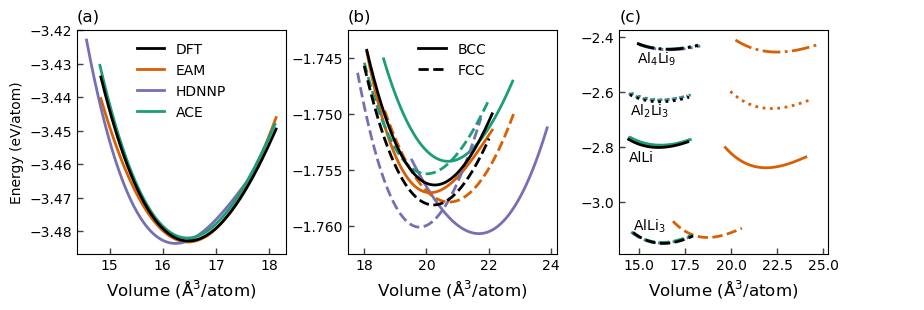

In [6]:


mlt = Multiplot(columns=3, width=700, ratio=0.3, wspace=0.3)

eam_vol, eam_en = get_en_vol('AlLi_eam', "Al", "fcc")
hdn_vol, hdn_en = get_en_vol('AlLi_hdnnp', "Al", "fcc")
ace_vol, ace_en = get_en_vol('AlLi_ace', "Al", "fcc")
dft_vol, dft_en = get_en_vol_dft("Al_fcc")

mlt[0,0].plot(dft_vol, dft_en, c='black', lw=2, label="DFT", zorder=10)
mlt[0,0].plot(eam_vol, eam_en, c=colors["r"], lw=2, label="EAM")
mlt[0,0].plot(hdn_vol, hdn_en, c=colors["b"], lw=2, label="HDNNP")
mlt[0,0].plot(ace_vol, ace_en, c=colors["g"], lw=2, label="ACE")

eam_vol, eam_en = get_en_vol('AlLi_eam', "Li", "bcc")
hdn_vol, hdn_en = get_en_vol('AlLi_hdnnp', "Li", "bcc")
ace_vol, ace_en = get_en_vol('AlLi_ace', "Li", "bcc")
dft_vol, dft_en = get_en_vol_dft("Li_bcc")

mlt[0,1].plot(dft_vol, dft_en, c='black', lw=2, label="BCC", zorder=10)
mlt[0,1].plot(eam_vol, eam_en, c=colors["r"], lw=2)
mlt[0,1].plot(hdn_vol, hdn_en, c=colors["b"], lw=2)
mlt[0,1].plot(ace_vol, ace_en, c=colors["g"], lw=2)

eam_vol, eam_en = get_en_vol('AlLi_eam', "Li", "fcc")
hdn_vol, hdn_en = get_en_vol('AlLi_hdnnp', "Li", "fcc")
ace_vol, ace_en = get_en_vol('AlLi_ace', "Li", "fcc")
dft_vol, dft_en = get_en_vol_dft("Li_fcc")

mlt[0,1].plot(dft_vol, dft_en, c='black', lw=2, label="FCC", zorder=10, ls='dashed')
mlt[0,1].plot(eam_vol, eam_en, c=colors["r"], lw=2, ls='dashed')
mlt[0,1].plot(hdn_vol, hdn_en, c=colors["b"], lw=2, ls='dashed')
mlt[0,1].plot(ace_vol, ace_en, c=colors["g"], lw=2, ls='dashed')


eam_vol, eam_en = get_en_vol('AlLi_eam', "Li2Al2", "cubic")
hdn_vol, hdn_en = get_en_vol('AlLi_hdnnp', "Li2Al2", "cubic")
ace_vol, ace_en = get_en_vol('AlLi_ace', "Li2Al2", "cubic")
dft_vol, dft_en = get_en_vol_dft("LiAl_mp-1067")

mlt[0,2].plot(dft_vol, dft_en, c='black', lw=2, zorder=10)
mlt[0,2].plot(eam_vol, eam_en, c=colors["r"], lw=2)
mlt[0,2].plot(hdn_vol, hdn_en, c=colors["b"], lw=2)
mlt[0,2].plot(ace_vol, ace_en, c=colors["g"], lw=2)
plt.text(min(dft_vol), min(dft_en)-0.05, r"AlLi")

eam_vol, eam_en = get_en_vol('AlLi_eam', "LiAl3", "cubic")
hdn_vol, hdn_en = get_en_vol('AlLi_hdnnp', "LiAl3", "cubic")
ace_vol, ace_en = get_en_vol('AlLi_ace', "LiAl3", "cubic")
dft_vol, dft_en = get_en_vol_dft("LiAl3_mp-10890")

mlt[0,2].plot(dft_vol, dft_en, c='black', lw=2, zorder=10, ls='dashed')
mlt[0,2].plot(eam_vol, eam_en, c=colors["r"], lw=2, ls='dashed')
mlt[0,2].plot(hdn_vol, hdn_en, c=colors["b"], lw=2, ls='dashed')
mlt[0,2].plot(ace_vol, ace_en, c=colors["g"], lw=2, ls='dashed')
plt.text(min(dft_vol), min(dft_en)+0.05, r"$\mathrm{AlLi}_3$")

eam_vol, eam_en = get_en_vol('AlLi_eam', "Li9Al4", "monoclinic")
hdn_vol, hdn_en = get_en_vol('AlLi_hdnnp', "Li9Al4", "monoclinic")
ace_vol, ace_en = get_en_vol('AlLi_ace', "Li9Al4", "monoclinic")
dft_vol, dft_en = get_en_vol_dft("Li9Al4_mp-568404")

mlt[0,2].plot(dft_vol, dft_en, c='black', lw=2, zorder=10, ls='dashdot')
mlt[0,2].plot(eam_vol, eam_en, c=colors["r"], lw=2, ls='dashdot')
mlt[0,2].plot(hdn_vol, hdn_en, c=colors["b"], lw=2, ls='dashdot')
mlt[0,2].plot(ace_vol, ace_en, c=colors["g"], lw=2, ls='dashdot')
plt.text(min(dft_vol), min(dft_en)-0.05, r"$\mathrm{Al_4Li_9}$")

eam_vol, eam_en = get_en_vol('AlLi_eam', "Li3Al2", "trigonal")
hdn_vol, hdn_en = get_en_vol('AlLi_hdnnp', "Li3Al2", "trigonal")
ace_vol, ace_en = get_en_vol('AlLi_ace', "Li3Al2", "trigonal")
dft_vol, dft_en = get_en_vol_dft("Li3Al2_mp-16506")

mlt[0,2].plot(dft_vol, dft_en, c='black', lw=2, zorder=10, ls='dotted')
mlt[0,2].plot(eam_vol, eam_en, c=colors["r"], lw=2, ls='dotted')
mlt[0,2].plot(hdn_vol, hdn_en, c=colors["b"], lw=2, ls='dotted')
mlt[0,2].plot(ace_vol, ace_en, c=colors["g"], lw=2, ls='dotted')
plt.text(min(dft_vol), min(dft_en)-0.05, r"$\mathrm{Al_2Li_3}$")

mlt[0,0].legend(frameon=False)
mlt[0,1].legend(frameon=False)
mlt[0,2].legend(frameon=False, bbox_to_anchor=[1.45, 0.5])

mlt[0,0].set_xlabel(r"Volume ($\mathrm{\AA}^3/$atom)", fontsize=12)
mlt[0,1].set_xlabel(r"Volume ($\mathrm{\AA}^3/$atom)", fontsize=12)
mlt[0,2].set_xlabel(r"Volume ($\mathrm{\AA}^3/$atom)", fontsize=12)
mlt[0,0].set_ylabel(r"Energy (eV/atom)")
mlt[0,0].set_title(r"(a)", loc='left', fontsize=12)
mlt[0,1].set_title(r"(b)", loc='left', fontsize=12)
mlt[0,2].set_title(r"(c)", loc='left', fontsize=12)
mlt[0,1].set_ylim(-1.7625, -1.7425)
plt.savefig("img_ev_curve.png", dpi=300, bbox_inches='tight')

# Convex Hull

In [7]:
def get_en(pot, compound, crystal_structure, points=False):
    df = data_murn.loc[(data_murn.potential==pot) & (data_murn.compound==compound) & (data_murn.crystal_structure==crystal_structure)]
    #print(df.job_id)
    return df.eq_energy.values[0]/df.n_atoms.values[0]

def get_en_dft(compound):
    df1 = df_dft_ref[df_dft_ref["compound"]==compound]
    vol = df1["volume"]
    en = df1["energy_per_atom"]
    popt = fit_bm(vol, en)
    volfit = np.linspace(min(vol), max(vol), 10000)
    enfit = birch_murnaghan(volfit, popt[0], popt[1], popt[2], popt[3])
    return min(enfit)

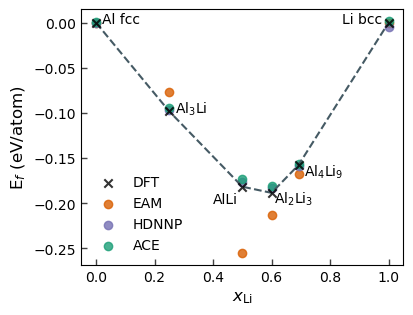

In [12]:
al_dft = get_en_dft('Al_fcc')
li_dft = get_en_dft('Li_bcc')

c0 = 0
s0_eam = get_en('AlLi_eam', 'Al', 'fcc') - ((1-c0)*al_dft + c0*li_dft)
s0_hdn = get_en('AlLi_hdnnp', 'Al', 'fcc') - ((1-c0)*al_dft + c0*li_dft)
s0_ace = get_en('AlLi_ace', 'Al', 'fcc') - ((1-c0)*al_dft + c0*li_dft)

c1 = 1/(1+3)
s1_dft = get_en_dft("LiAl3_mp-10890") - ((1-c1)*al_dft + c1*li_dft) 
s1_eam = get_en('AlLi_eam', 'LiAl3', 'cubic') - ((1-c1)*al_dft + c1*li_dft)
s1_hdn = get_en('AlLi_hdnnp', 'LiAl3', 'cubic') - ((1-c1)*al_dft + c1*li_dft)
s1_ace = get_en('AlLi_ace', 'LiAl3', 'cubic') - ((1-c1)*al_dft + c1*li_dft)

c2 = 1/(1+1)
s2_dft = get_en_dft("LiAl_mp-1067") - ((1-c2)*al_dft + c2*li_dft) 
s2_eam = get_en('AlLi_eam', 'Li2Al2', 'cubic') - ((1-c2)*al_dft + c2*li_dft)
s2_hdn = get_en('AlLi_hdnnp', 'Li2Al2', 'cubic') - ((1-c2)*al_dft + c2*li_dft)
s2_ace = get_en('AlLi_ace', 'Li2Al2', 'cubic') - ((1-c2)*al_dft + c2*li_dft)

c3 = 3/(3+2)
s3_dft = get_en_dft("Li3Al2_mp-16506") - ((1-c3)*al_dft + c3*li_dft) 
s3_eam = get_en('AlLi_eam', 'Li3Al2', 'trigonal') - ((1-c3)*al_dft + c3*li_dft)
s3_hdn = get_en('AlLi_hdnnp', 'Li3Al2', 'trigonal') - ((1-c3)*al_dft + c3*li_dft)
s3_ace = get_en('AlLi_ace', 'Li3Al2', 'trigonal') - ((1-c3)*al_dft + c3*li_dft)

c4 = 9/(4+9)
s4_dft = get_en_dft("Li9Al4_mp-568404") - ((1-c4)*al_dft + c4*li_dft) 
s4_eam = get_en('AlLi_eam', 'Li9Al4', 'monoclinic') - ((1-c4)*al_dft + c4*li_dft)
s4_hdn = get_en('AlLi_hdnnp', 'Li9Al4', 'monoclinic') - ((1-c4)*al_dft + c4*li_dft)
s4_ace = get_en('AlLi_ace', 'Li9Al4', 'monoclinic') - ((1-c4)*al_dft + c4*li_dft)

c5 = 1
s5_dft = get_en_dft("Li_fcc") - ((1-c5)*al_dft + c5*li_dft) 
s5_eam = get_en('AlLi_eam', 'Li', 'bcc') - ((1-c5)*al_dft + c5*li_dft) 
s5_hdn = get_en('AlLi_hdnnp', 'Li', 'bcc') - ((1-c5)*al_dft + c5*li_dft) 
s5_ace = get_en('AlLi_ace', 'Li', 'bcc') - ((1-c5)*al_dft + c5*li_dft) 

mlt = Multiplot(width=300, ratio=0.8, )#wspace=0.3)

a=0.8
mlt[0,0].scatter([c0, c1, c2, c3, c4, c5], [0, s1_dft, s2_dft, s3_dft, s4_dft, 0], c='black', marker='x', alpha=a, label='DFT', zorder=10)
mlt[0,0].scatter([c0, c1, c2, c3, c4, c5], [s0_eam, s1_eam, s2_eam, s3_eam, s4_eam, s5_eam], c=colors["r"], alpha=a, label='EAM')
mlt[0,0].scatter([c0, c1, c2, c3, c4, c5], [s0_hdn, s1_hdn, s2_hdn, s3_hdn, s4_hdn, s5_hdn], c=colors["b"], alpha=a, label='HDNNP')
mlt[0,0].scatter([c0, c1, c2, c3, c4, c5], [s0_ace, s1_ace, s2_ace, s3_ace, s4_ace, s5_ace], c=colors["g"], alpha=a, label='ACE')

mlt[0,0].plot([0, c1, c2, c3, c4, 1], [0, s1_dft, s2_dft, s3_dft, s4_dft, 0], c=accent['lgrey'], ls='dashed')
mlt[0,0].legend(frameon=False)
mlt[0,0].set_xlabel(r"$x_\mathrm{Li}$",fontsize="12")
mlt[0,0].set_ylabel(r"E$_f$ (eV/atom)",fontsize="12")

plt.text(0.02, -0.00, 'Al fcc')
plt.text(0.27, -0.10, r'Al$_3$Li')
plt.text(0.4, -0.20, r'AlLi')
plt.text(0.61, -0.20, r'Al$_2$Li$_3$')
plt.text(0.71, -0.17, r'Al$_4$Li$_9$')
plt.text(0.84, -0.00, 'Li bcc')
plt.savefig("img_convex_hull.png", dpi=300, bbox_inches='tight')